In [1]:
!pip install --upgrade tables
!pip install eli5
!pip install xgboost

     |████████████████████████████████| 4.3MB 5.1MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 4.9MB/s 


In [2]:
cd '/content/drive/My Drive/Colab Notebooks/dw-matrix/matrix_two/dw_matrix_car'

/content/drive/My Drive/Colab Notebooks/dw-matrix/matrix_two/dw_matrix_car


In [0]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, KFold

import eli5
from eli5.sklearn import PermutationImportance

In [4]:
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

## Feature Engineering

In [0]:
suffix_cat = '__cat'

for feat in df.columns:
  if isinstance(df[feat][0], list): continue

  factorized_values = df[feat].factorize()[0]
  if suffix_cat in feat:
    df[feat] = factorized_values
  else:
    df[feat + suffix_cat] = factorized_values



In [6]:
cat_feats = [x for x in df.columns if suffix_cat in x]
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [0]:
def run_model(model, feats):
  X = df[feats].values
  y = df['price_value'].values

  scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
  return np.mean(scores), np.std(scores)

## Decision Tree Regressor

In [8]:
run_model(DecisionTreeRegressor(max_depth=5), cat_feats)

(-19695.13091100928, 148.72570644015792)

## Random Forest

In [9]:
model = RandomForestRegressor(max_depth=5, n_estimators=50, random_state=0)
run_model(model, cat_feats)

(-18718.657185256638, 64.5424578125788)

## XGBoost

In [10]:
xgb_params = {
    'max_depth':5, 
    'n_estimators':50, 
    'learning_rate':0.1,
    'seed':0
}

run_model(xgb.XGBRegressor(**xgb_params), cat_feats)

[22:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-13108.379065811214, 74.32158265003798)

In [0]:
X = df[cat_feats].values
y = df['price_value'].values

## Valuable features

In [12]:
m = xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.1, seed=0)
m.fit(X, y)

imp = PermutationImportance(m, random_state=0).fit(X, y)
eli5.show_weights(imp, feature_names = cat_feats)

[22:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Weight,Feature
0.1194 ± 0.0031,param_napęd__cat
0.1132 ± 0.0032,param_rok-produkcji__cat
0.1090 ± 0.0025,param_stan__cat
0.0619 ± 0.0025,param_skrzynia-biegów__cat
0.0568 ± 0.0016,param_faktura-vat__cat
0.0489 ± 0.0014,param_moc__cat
0.0273 ± 0.0007,param_marka-pojazdu__cat
0.0242 ± 0.0013,feature_kamera-cofania__cat
0.0212 ± 0.0008,param_typ__cat
0.0174 ± 0.0008,param_pojemność-skokowa__cat


In [0]:
df['param_rok-produkcji'] = df['param_rok-produkcji'].map(lambda x: -1 if str(x) == 'None' else int(x))

In [15]:
feats = ['param_napęd__cat','param_rok-produkcji','param_stan__cat','param_skrzynia-biegów__cat','param_faktura-vat__cat','param_moc','param_marka-pojazdu__cat','feature_kamera-cofania__cat','param_typ__cat','param_pojemność-skokowa','seller_name__cat','feature_wspomaganie-kierownicy__cat','param_model-pojazdu__cat','param_wersja__cat','param_kod-silnika__cat','feature_system-start-stop__cat','feature_asystent-pasa-ruchu__cat','feature_czujniki-parkowania-przednie__cat','feature_łopatki-zmiany-biegów__cat','feature_regulowane-zawieszenie__cat']

run_model(xgb.XGBRegressor(**xgb_params), feats)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '218 KM'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '90 KM'

  FitFailedWarning)


(nan, nan)

In [0]:
df['param_moc'] = df['param_moc'].map(lambda x: -1 if str(x) == 'None' else int(x.split()[0]))

In [17]:
df['param_pojemność-skokowa']

0           898 cm3
2         1 560 cm3
3         3 000 cm3
4         1 560 cm3
5         1 984 cm3
            ...    
160609    1 120 cm3
160610    1 200 cm3
160611    1 900 cm3
160614    2 500 cm3
160615    1 360 cm3
Name: param_pojemność-skokowa, Length: 106494, dtype: object

In [0]:
df['param_pojemność-skokowa'] = df['param_pojemność-skokowa'].map(lambda x: -1 if str(x) == 'None' else int(x[:-4].replace(' ', '')))

In [19]:
run_model(xgb.XGBRegressor(**xgb_params), feats)

[22:49:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-9569.227198767323, 72.83561801421891)

In [22]:
corr_matrix = df.corr()
corr_matrix['price_value'].sort_values(ascending=False)

price_value                    1.000000
param_moc                      0.565211
param_faktura-vat__cat         0.475397
price_value__cat               0.473163
feature_kamera-cofania__cat    0.464058
                                 ...   
seller_type__cat              -0.226989
param_oferta-od__cat          -0.227024
param_rok-produkcji__cat      -0.290181
feature_bluetooth__cat        -0.365952
param_stan__cat               -0.414209
Name: price_value, Length: 229, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0bc8de0b38>,
      dtype=object)

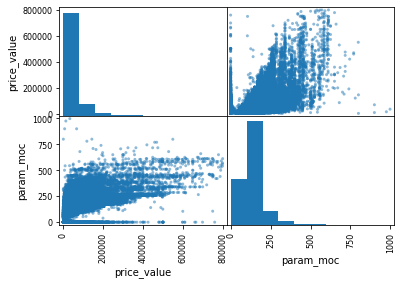

In [23]:
from pandas.plotting import scatter_matrix

corr_attribs = ['price_value', 'param_moc']
scatter_matrix(df[corr_attribs])